In [1]:
import os
from pprint import pprint
from csv import reader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score,v_measure_score
from sklearn import linear_model,preprocessing

from scipy.optimize import minimize, Bounds
from scipy.linalg import orth, eigh
from scipy.stats import mode

import statsmodels.api
import statsmodels as sm

import anndata
import scanpy

from glmpca import glmpca

import csv

from tqdm import trange

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
%matplotlib widget

In [2]:
from importlib import reload

# Load Belayer functions

import sys

sys.path.append('src')
from utils_IO import *

from harmonic import *
from region_cost_fun import *
from dprelated import *
from dp_post_processing import *
from general_helper_funcs import * # Cong added the helper function script from belayer-develop to belayer repo
from precompute_likelihood import *
from dp_linear_boundary import *
import svg
from slideseq_helpers import *

# C. diff / C1 cropped

In [3]:
input_10x_folder='C.diff.C1_crop/'
count, coords, barcodes, gene_labels=read_input_10xdirectory(input_10x_folder)

G,N=count.shape

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_file='C.diff.C1_crop/list_boundaries_colon.npy'
boundary_list = read_boundary_list(boundary_file, fullpoints)

In [4]:
# harmonic interpolation
spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))

interpolation = har.interpolation_using_list( boundary_list )
depth = interpolation[in_tissue]

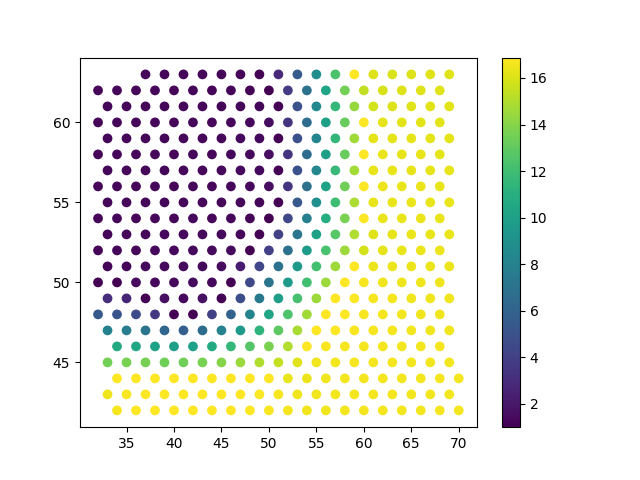

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.scatter(coords[:,1],coords[:,0],c=depth)
plt.colorbar()

# C. diff / C1

In [6]:
input_10x_folder='C.diff.C1/'
count, coords, barcodes, gene_labels=read_input_10xdirectory(input_10x_folder)

G,N=count.shape

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_file='C.diff.C1/list_boundaries_full.npy'
boundary_list = read_boundary_list(boundary_file, fullpoints)

In [7]:
# harmonic interpolation
spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))

interpolation = har.interpolation_using_list( boundary_list )
depth = interpolation[in_tissue]

In [8]:
gammas = np.load('C.diff.C1/list_boundaries_full.npy', allow_pickle=True)

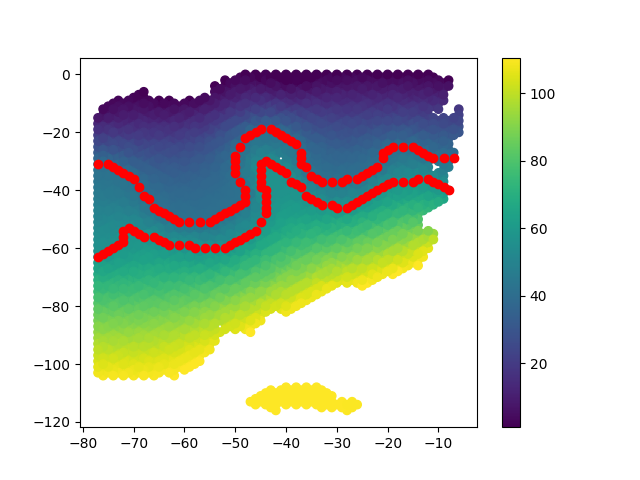

In [9]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.scatter(-coords[:,0],-coords[:,1],c=depth)
plt.colorbar()
plt.scatter(-gammas[1][:,0],-gammas[1][:,1], color='red')
plt.scatter(-gammas[2][:,0],-gammas[2][:,1], color='red')

In [10]:
depth_df = pd.DataFrame({'barcode': barcodes, 'row': coords[:, 0], 'col': coords[:, 1], 'depth': depth})
depth_df.to_csv('C.diff.C1/depth.csv', index=False)

In [11]:
LE = set([(row, col) for row, col in gammas[1]])
ES = set([(row, col) for row, col in gammas[2]])

In [12]:
df = pd.DataFrame(count.T, index=barcodes, columns=gene_labels)
df['depth'] = depth
df['row'] = coords[:, 0]
df['col'] = coords[:, 1]

In [13]:
df['depth2'] = df['depth'].round()

In [14]:
df['LE'] = df[['row', 'col']].apply(lambda x: (x['row'], x['col']) in LE, axis=1)
df['ES'] = df[['row', 'col']].apply(lambda x: (x['row'], x['col']) in ES, axis=1)

In [15]:
LE_depth = df[df['LE']]['depth'].mean()
ES_depth = df[df['ES']]['depth'].mean()

In [135]:
def plot_expression_by_depth(genes, title, top10 = False):
    # import matplotlib.pyplot as plt
    # %matplotlib inline

    max_expression = 0
    fig, ax = plt.subplots(figsize=(8,5))
    genes_by_depth = df.groupby('depth2')[genes].mean()
    if top10:
        genes_max = genes_by_depth.max()
        genes_max = genes_max.sort_values(ascending=False)
        genes = genes_max.index[:10]
    max_expression = genes_by_depth.max().max() *1.1
    min_expression = genes_by_depth.min().min()
    genes_by_depth.reset_index(inplace=True)
    min_depth = genes_by_depth['depth2'].min()
    max_depth = genes_by_depth['depth2'].max()
    ax.plot([LE_depth, LE_depth], [min_expression, max_expression], linestyle='--', color='red', alpha=0.5, zorder=5)
    ax.plot([ES_depth, ES_depth], [min_expression, max_expression], linestyle='--', color='red', alpha=0.5, zorder=5)
    ax.plot([min_depth, LE_depth], [max_expression, max_expression], label='lumen', lw=5, color='lightgray', zorder=5)
    ax.plot([LE_depth, ES_depth], [max_expression, max_expression], label='epithelium', lw=5, color='darkgray', zorder=5)
    ax.plot([ES_depth, max_depth], [max_expression, max_expression], label='submucosa', lw=5, color='gray', zorder=5)
    for gene in genes:
        ax.scatter(genes_by_depth['depth2'], genes_by_depth[gene], label=gene, zorder=10)
    ax.set_ylabel('Mean LogNorm Expression')
    ax.set_xlabel('Depth')
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,1))
    fig.subplots_adjust(right=0.75)
    return fig

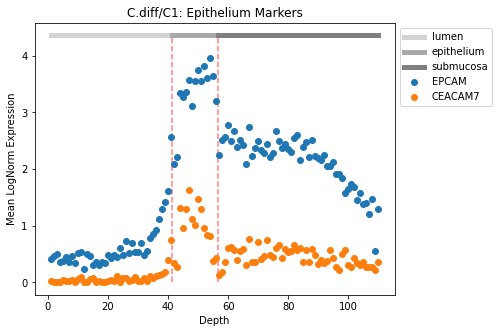

In [139]:
plot_expression_by_depth(['EPCAM', 'CEACAM7'], title='C.diff/C1: Epithelium Markers')
fig.savefig('Cdiff-C1-Epithelium-Markers.png')

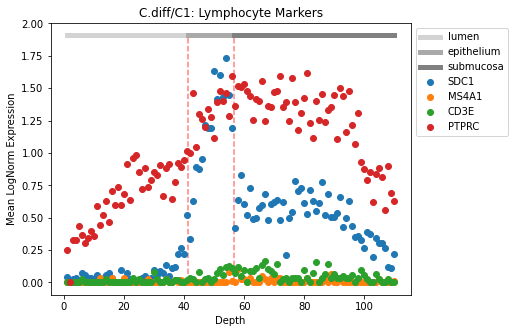

In [140]:
plot_expression_by_depth(['SDC1', 'MS4A1', 'CD3E', 'PTPRC'], title='C.diff/C1: Lymphocyte Markers')
fig.savefig('Cdiff-C1-Lymphocyte-Markers.png')

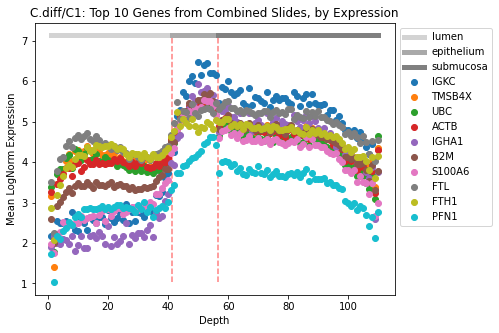

In [141]:
plot_expression_by_depth(pd.read_csv('/mnt/data5/output/explore/combined_mean_lognorm_expression.csv')['gene'].head(10), title='C.diff/C1: Top 10 Genes from Combined Slides, by Expression')
fig.savefig('Cdiff-C1-Top-10-Combined-Genes.png')

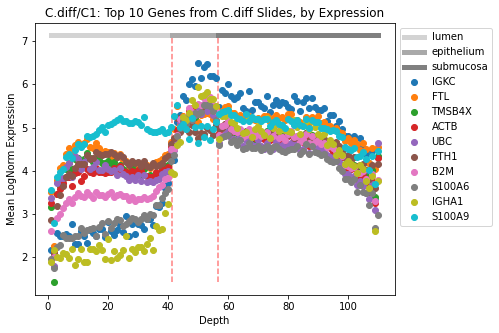

In [142]:
plot_expression_by_depth(pd.read_csv('/mnt/data5/output/explore/cdiff_mean_lognorm_expression.csv')['gene'].head(10), title='C.diff/C1: Top 10 Genes from C.diff Slides, by Expression')
fig.savefig('Cdiff-C1-Top-10-Cdiff-Genes.png')

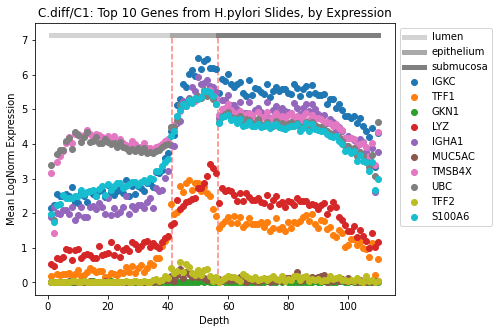

In [143]:
plot_expression_by_depth(pd.read_csv('/mnt/data5/output/explore/hpylori_mean_lognorm_expression.csv')['gene'].head(10), title='C.diff/C1: Top 10 Genes from H.pylori Slides, by Expression')
fig.savefig('Cdiff-C1-Top-10-Hpylori-Genes.png')

In [144]:
Tcell = pd.read_excel('Tcell.xlsx', skiprows=1)
genes = pd.read_csv('C.diff.C1/filtered_feature_bc_matrix/features.tsv.gz', sep='\t', header=None, names=['id', 'gene', 'type'])['gene']

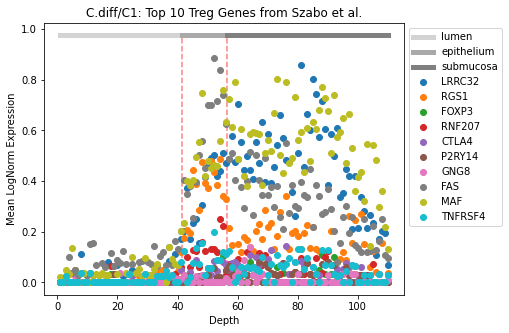

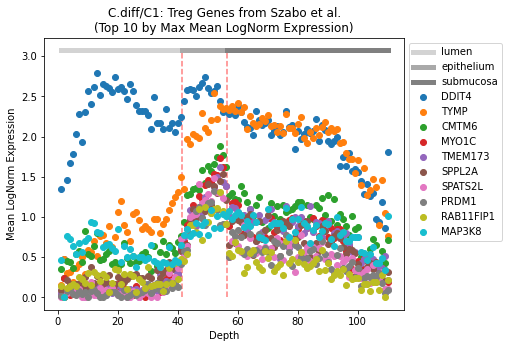

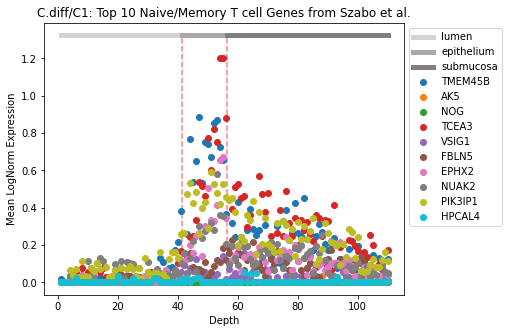

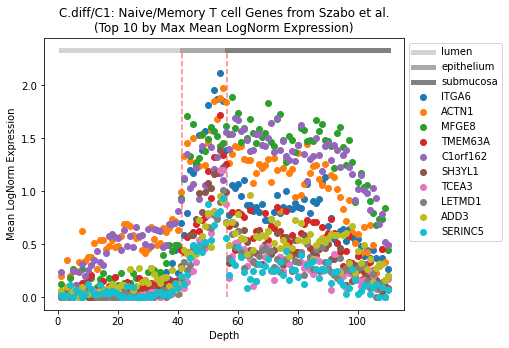

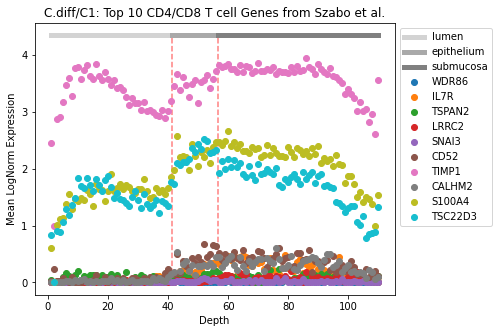

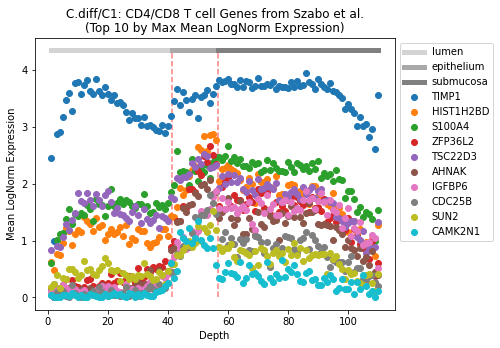

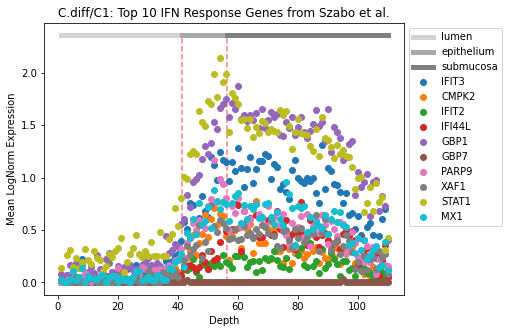

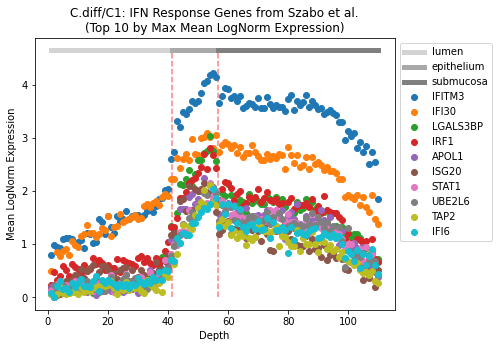

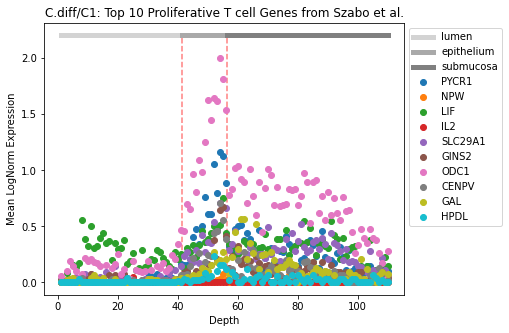

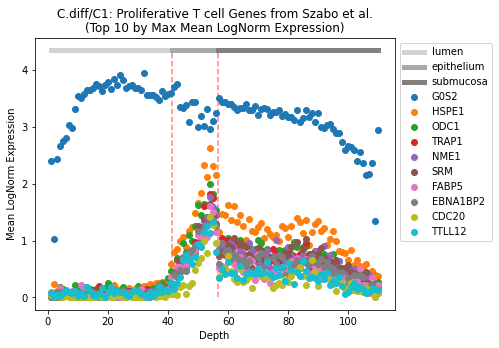

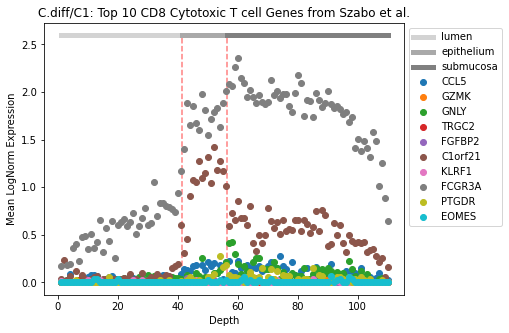

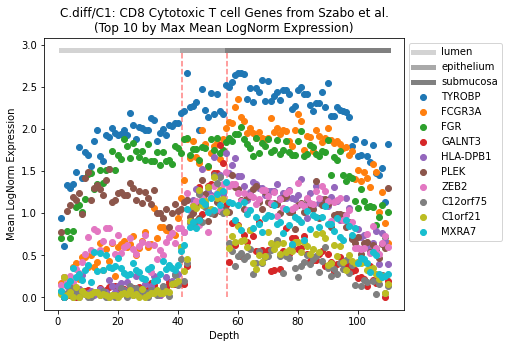

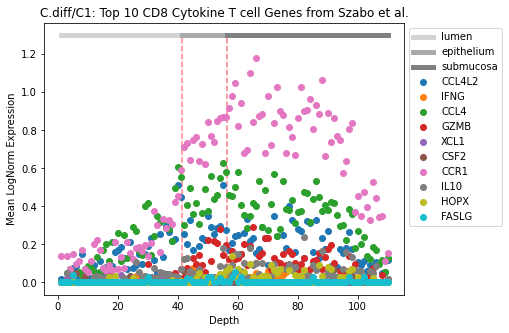

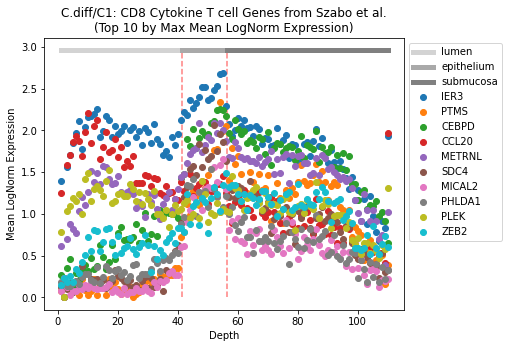

In [138]:
for tcell_type, tcell_title in zip(Tcell.columns, ['Treg', 'Naive/Memory T cell', 'CD4/CD8 T cell', 'IFN Response', 'Proliferative T cell', 'CD8 Cytotoxic T cell', 'CD8 Cytokine T cell']):
    fig = plot_expression_by_depth(Tcell.loc[Tcell[tcell_type].isin(genes), tcell_type].head(10), title=f'C.diff/C1: Top 10 {tcell_title} Genes from Szabo et al.')
    fig.savefig(f'Cdiff-C1-Top-10-{tcell_title.replace("/", "-").replace(" ", "-")}-Genes.png')
    fig = plot_expression_by_depth(Tcell.loc[Tcell[tcell_type].isin(genes), tcell_type], title=f'C.diff/C1: {tcell_title} Genes from Szabo et al.\n(Top 10 by Max Mean LogNorm Expression)', top10=True)
    fig.savefig(f'Cdiff-C1-{tcell_title.replace("/", "-").replace(" ", "-")}-Top-10-Expressed-Genes.png')